# Úkol č. 3 - Segmentace zákazníků e-shopu
**Deadline úkolu je uveden na [course pages](https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html).**

Jednou z důležitých aplikací shlukování je **segmentace zákazníků** (angl. **customer segmentation**). 

Předpokládejme, že máme následující obchodní údaje o prodejích (resp. nákupech z pohledu zákazníků):
TransactionID - ID nákupu,
CustomerID - ID zákazníka, 
Date - datum nákupu, 
Total - celková cena nákupu.

Chceme najít segmenty zákazníků, kteří se chovají podobně. K tomu je dobré informace z jednotlivých nákupů pro individuální zákazníky agregovat. Tj. získat pro každého zákazníka jeden řádek.

Populárním přístupem je **RFM**, což znamená:

- **R**ecency: Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka).
- **F**requency: Počet nákupů. Občas se vynechávají zákazníci s jediným nákupem. Pro jednoduchost je zde ale necháme.
- **M**onetary: Celková suma, kterou daný zákazník utratil.

## Zdroj dat
Budeme pracovat s daty z jednoho (skoro) vymyšleného eshopu, která jsou v přiloženém souboru `eshop.csv`.

## Pokyny k vypracování

Ve všech bodech zadání uvažujte aktuální datum jako datum poslední transakce (19. 12. 2015), nikoliv dnešek. Tváříme se, že jde o aktuální data.

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
- Vytvořte `rfm` data frame, kde každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše.
- Pomocí algoritmu `K-means` proveďte shlukování. Nějakým způsobem také odhadněte nejlepší počet shluků (podrobně vysvětlete).
- Zabývejte se vlivem přeškálování dat (standardizace příznaků). Tj. určete, zda je přeškálování vhodné, a proveďte ho.
- Interpretujte jednotlivé shluky. Použijte získané shluky k odlišení "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) od nezajímavých  zákazníků (vysoká recency, nízká frequency, nízká monetary).

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
- (až +4 body) Proveďte analýzu vytvořených shluků pomocí metody silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- (až +4 body) Zkuste provést to samé s modifikovanou verzí **RFM**, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

# Solution:

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage

To start off, I read the dataset from the file and reviewed it using some useful functions and methods:

In [179]:
df = pd.read_csv("eshop.csv")
display(df)
display(df.info())
print("Unique customers:", df["Customer ID"].nunique())

,Customer ID,Date,Subtotal,Country
0,34,6/21/2007,86.00,Czech Republic
1,38,6/27/2007,38.40,Czech Republic
2,47,7/2/2007,53.50,Slovakia
3,61,7/14/2007,7.00,Czech Republic
4,78,7/21/2007,55.50,Czech Republic
...,...,...,...,...
22403,15356,12/18/2015,31.87,Czech Republic
22404,15357,12/18/2015,6.10,Czech Republic
22405,15358,12/18/2015,153.23,Czech Republic
22406,15359,12/19/2015,19.15,Czech Republic


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22408 entries, 0 to 22407
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Customer ID  22408 non-null  int64  
 1   Date         22408 non-null  object 
 2   Subtotal     22408 non-null  float64
 3   Country      22405 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 700.4+ KB


None

Unique customers: 12829


## Normal RFM

The first dataset I needed to make was normal RFM described in the task text above. I used `pandas.DataFrame.groupby` and `pandas.DataFrame.agg` functions to aggregate the customers and extract needed information about them from the dataset.

In [180]:
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df["Difference_in_days"] = (df["Date"].max() - df["Date"]).dt.days

rfm = df.groupby("Customer ID").agg({
    "Difference_in_days": "min",
    "Customer ID": "count",
    "Subtotal": "sum"
}).rename(columns={
    "Difference_in_days": "Recency",
    "Customer ID": "Frequency",
    "Subtotal": "Monetary"
})
display(rfm)

,Recency,Frequency,Monetary
Customer ID,,,
7,311,3,15.54
9,3050,1,13.20
30,3025,1,36.20
34,3103,1,86.00
38,3097,1,38.40
...,...,...,...
15356,1,1,31.87
15357,1,1,6.10
15358,1,1,153.23


Then I used the method described in the tutorials (`yellowbrick.cluster.KElbowVisualizer`) to find the optimal number of clusters for the dataset created above. This relulted in `k = 4`.

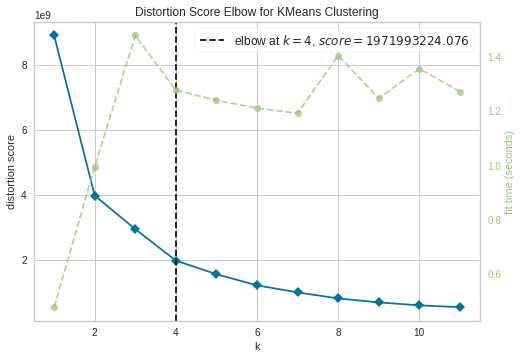

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [181]:
visualizer = KElbowVisualizer(KMeans(), k=(1,12))
visualizer.fit(rfm)
visualizer.show()

Having the output from the previous cell, I finally trained the model and got the clusters. Cluster #3 here contains "superstar" customers, as they have the highest mean of monetary and frequency, and theis recency is also the lowest. Cluster #1, in contrast, has the most uninteresting customers, as they have the highest recency and the lowest frequency and monetary.

In [182]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=1).fit(rfm)
rfm["Cluster"] = kmeans.labels_

clusters = [rfm[rfm["Cluster"] == num] for num in rfm["Cluster"].unique()]
for cluster in clusters:
    display(cluster.describe())

,Recency,Frequency,Monetary,Cluster
count,4525.000000,4525.000000,4525.000000,4525.0
mean,325.132155,2.169724,194.488230,2.0
std,213.792589,2.441520,299.141434,0.0
min,0.000000,1.000000,1.180000,2.0
25%,129.000000,1.000000,37.860000,2.0
50%,318.000000,1.000000,82.210000,2.0
75%,495.000000,2.000000,202.820000,2.0
max,841.000000,24.000000,2172.760000,2.0


,Recency,Frequency,Monetary,Cluster
count,3504.000000,3504.000000,3504.000000,3504.0
mean,2046.074772,1.283676,84.507029,1.0
std,317.851454,0.905470,116.976454,0.0
min,1598.000000,1.000000,1.680000,1.0
25%,1790.000000,1.000000,27.245000,1.0
50%,1970.000000,1.000000,49.575000,1.0
75%,2247.000000,1.000000,96.875000,1.0
max,3103.000000,28.000000,2154.510000,1.0


,Recency,Frequency,Monetary,Cluster
count,4743.000000,4743.000000,4743.000000,4743.0
mean,1156.768712,1.550495,121.264738,0.0
std,251.667049,1.390731,176.462112,0.0
min,729.000000,1.000000,1.640000,0.0
25%,936.000000,1.000000,32.290000,0.0
50%,1154.000000,1.000000,65.370000,0.0
75%,1372.500000,2.000000,139.080000,0.0
max,1633.000000,23.000000,2311.270000,0.0


,Recency,Frequency,Monetary,Cluster
count,57.000000,57.000000,57.000000,57.0
mean,320.789474,12.947368,4342.334737,3.0
std,365.802481,8.369633,2997.071391,0.0
min,2.000000,2.000000,2332.120000,3.0
25%,32.000000,7.000000,2768.060000,3.0
50%,116.000000,11.000000,3307.130000,3.0
75%,498.000000,17.000000,4735.500000,3.0
max,1230.000000,45.000000,21392.380000,3.0


Here I decided to visualize these clusters, but the dataset had three columns, so I looked for the **3d visualizations** with `matplotlib` and got this code and result:

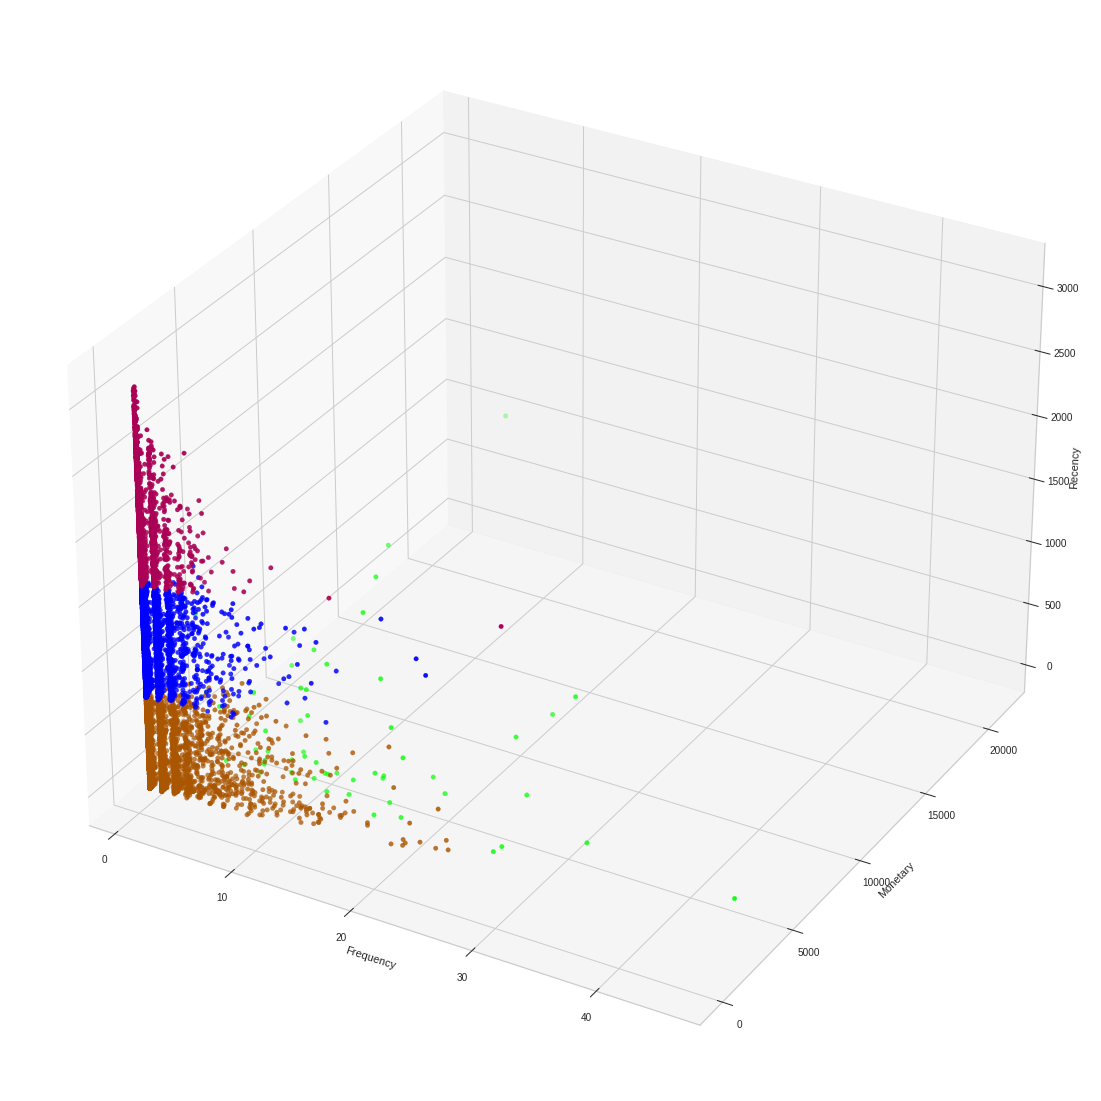

In [183]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm["Frequency"], rfm["Monetary"], rfm["Recency"], c=rfm["Cluster"], cmap="brg")
ax.set_xlabel("Frequency")
ax.set_ylabel("Monetary")
ax.set_zlabel("Recency")
plt.show()

The 3d scatter plot could not rotate, so to have better understanding of the dataset I decided to create more visualizations to look at the projections of the population on every plane in the 3d space:

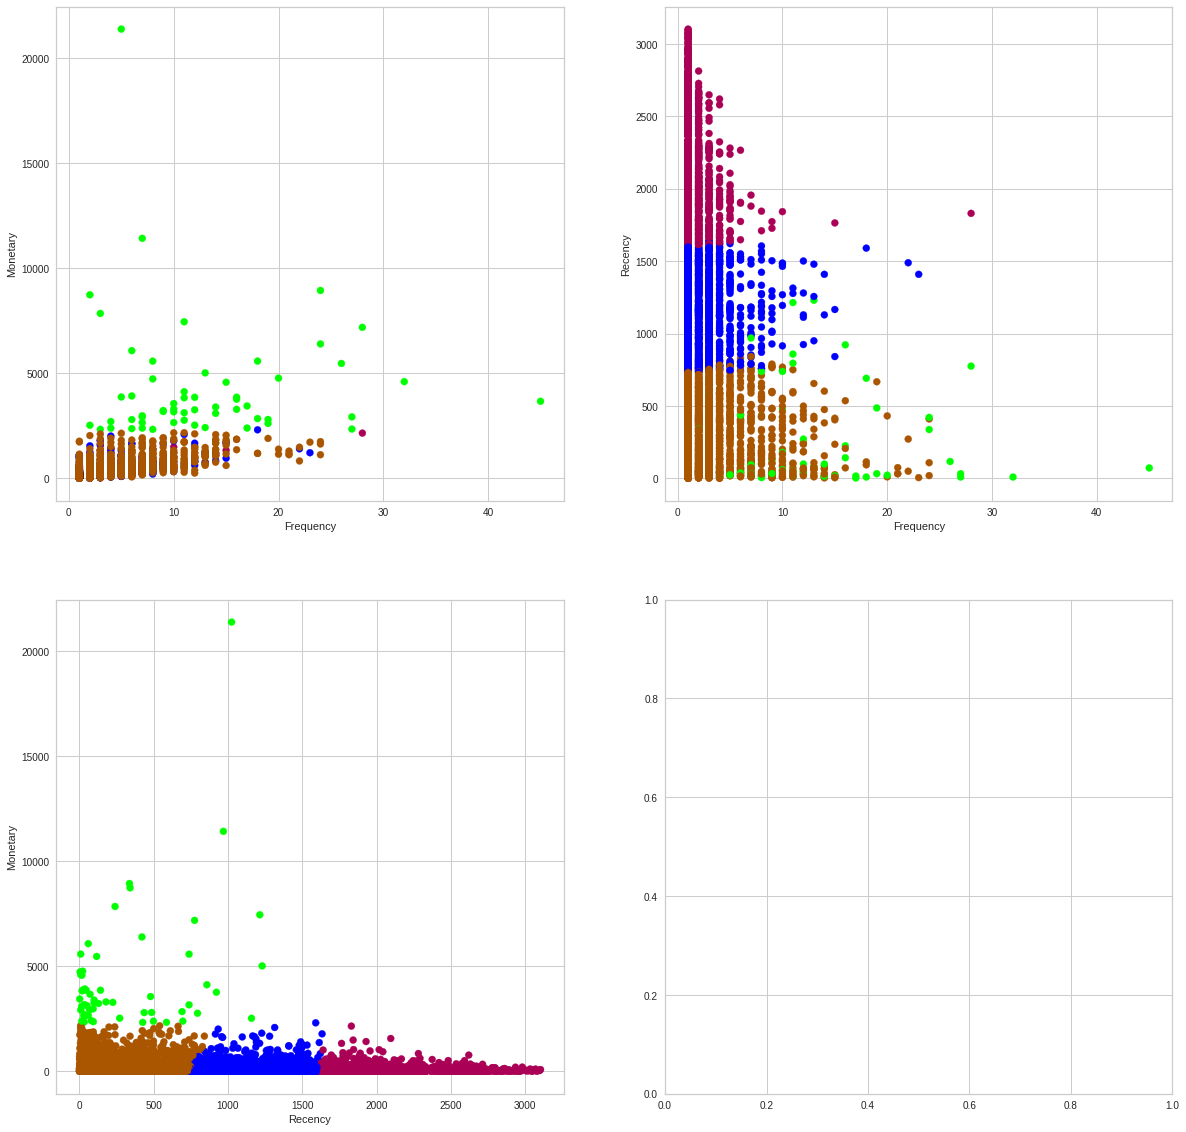

In [184]:
fig, ((ax1, ax2), (ax3, _)) = plt.subplots(2, 2, figsize=(20, 20))

ax1.scatter(rfm["Frequency"], rfm["Monetary"], c=rfm["Cluster"], cmap="brg")
ax1.set_xlabel("Frequency")
ax1.set_ylabel("Monetary")

ax2.scatter(rfm["Frequency"], rfm["Recency"], c=rfm["Cluster"], cmap="brg")
ax2.set_xlabel("Frequency")
ax2.set_ylabel("Recency")

ax3.scatter(rfm["Recency"], rfm["Monetary"], c=rfm["Cluster"], cmap="brg")
ax3.set_xlabel("Recency")
ax3.set_ylabel("Monetary")

plt.show()

## Scaled RFM
The next part of the task was to normalize the values in the RFM dataset and see if there would be any changes in the results. To scale the numeric values, I used the `sklearn.preprocessor.MinMaxScaler`.

In [185]:
column_names = ["Recency", "Frequency", "Monetary"]
rfm_scaled = pd.DataFrame(MinMaxScaler().fit_transform(rfm[column_names]), columns=column_names)
display(rfm_scaled)

,Recency,Frequency,Monetary
0,0.100226,0.045455,0.000671
1,0.982920,0.000000,0.000562
2,0.974863,0.000000,0.001637
3,1.000000,0.000000,0.003965
4,0.998066,0.000000,0.001740
...,...,...,...
12824,0.000322,0.000000,0.001435
12825,0.000322,0.000000,0.000230
12826,0.000322,0.000000,0.007108
12827,0.000000,0.000000,0.000840


Next steps are quite similar to the first part of the solution. This one though differs by having another output from the elbow visualizer.

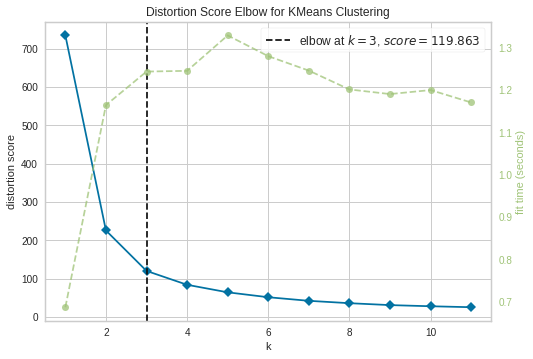

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [186]:
visualizer = KElbowVisualizer(KMeans(), k=(1,12))
visualizer.fit(rfm_scaled)
visualizer.show()

The output from the cell above was `k = 3`, so I use it as a number of clusters here:

In [187]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=1).fit(rfm_scaled)
rfm_scaled["Cluster"] = kmeans.labels_

clusters = [rfm_scaled[rfm_scaled["Cluster"] == num] for num in rfm_scaled["Cluster"].unique()]
for cluster in clusters:
    display(cluster.describe())

,Recency,Frequency,Monetary,Cluster
count,4654.000000,4654.000000,4654.000000,4654.0
mean,0.106639,0.028915,0.010649,0.0
std,0.070607,0.064099,0.023647,0.0
min,0.000000,0.000000,0.000000,0.0
25%,0.041573,0.000000,0.001712,0.0
50%,0.104415,0.000000,0.003791,0.0
75%,0.163632,0.022727,0.009497,0.0
max,0.256204,1.000000,0.418116,0.0


,Recency,Frequency,Monetary,Cluster
count,3484.000000,3484.000000,3484.000000,3484.0
mean,0.660210,0.006517,0.003940,1.0
std,0.102147,0.020690,0.005676,0.0
min,0.518208,0.000000,0.000023,1.0
25%,0.578150,0.000000,0.001219,1.0
50%,0.635514,0.000000,0.002271,1.0
75%,0.724460,0.000000,0.004491,1.0
max,1.000000,0.613636,0.100664,1.0


,Recency,Frequency,Monetary,Cluster
count,4691.000000,4691.000000,4691.000000,4691.0
mean,0.375653,0.012883,0.006278,2.0
std,0.080128,0.032779,0.019863,0.0
min,0.240735,0.000000,0.000022,2.0
25%,0.306478,0.000000,0.001463,2.0
50%,0.374476,0.000000,0.003008,2.0
75%,0.445053,0.022727,0.006548,2.0
max,0.520142,0.500000,1.000000,2.0


Again, I drew the scatter plot and came to a conclusion, that scaling did not change the data structure, but changed the number of clusters given by the elbow visualizer. So, these clusters are a bit different from the ones found before.

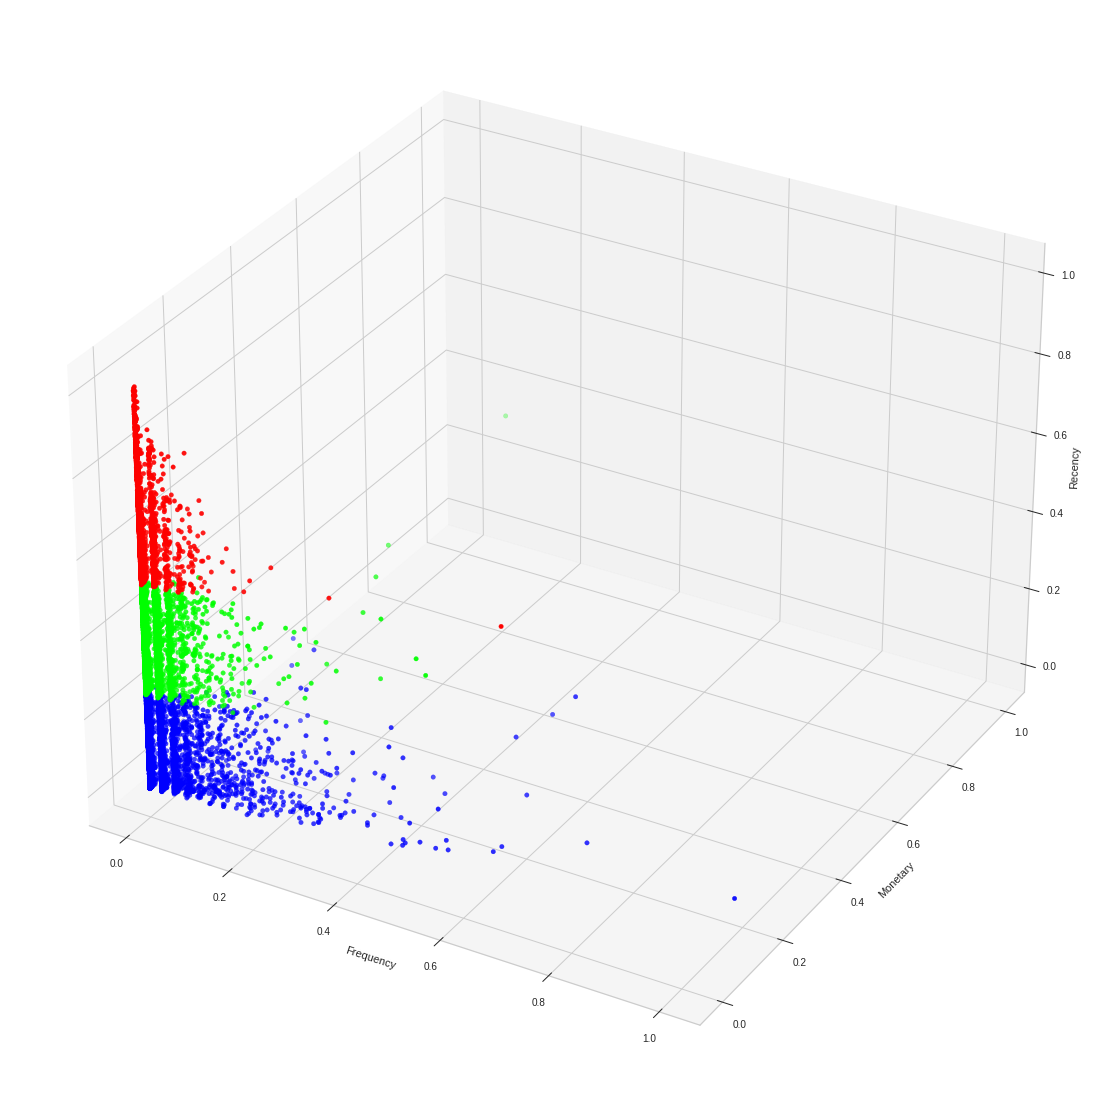

In [188]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm_scaled["Frequency"], rfm_scaled["Monetary"], 
           rfm_scaled["Recency"], c=rfm_scaled["Cluster"], cmap="brg")
ax.set_xlabel("Frequency")
ax.set_ylabel("Monetary")
ax.set_zlabel("Recency")
plt.show()

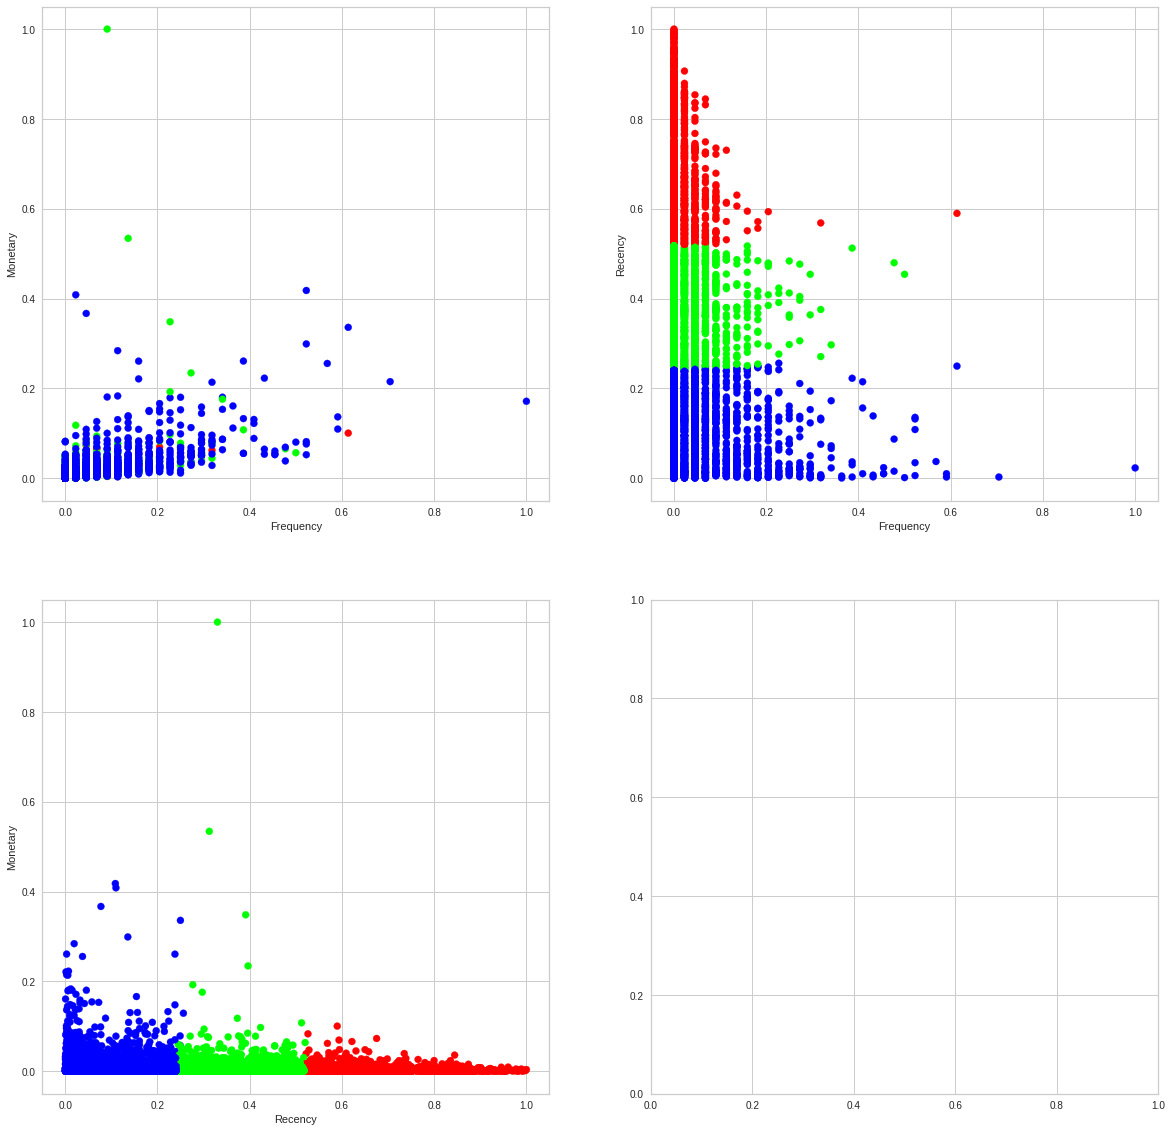

In [189]:
fig, ((ax1, ax2), (ax3, _)) = plt.subplots(2, 2, figsize=(20, 20))

ax1.scatter(rfm_scaled["Frequency"], rfm_scaled["Monetary"], c=rfm_scaled["Cluster"], cmap="brg")
ax1.set_xlabel("Frequency")
ax1.set_ylabel("Monetary")

ax2.scatter(rfm_scaled["Frequency"], rfm_scaled["Recency"], c=rfm_scaled["Cluster"], cmap="brg")
ax2.set_xlabel("Frequency")
ax2.set_ylabel("Recency")

ax3.scatter(rfm_scaled["Recency"], rfm_scaled["Monetary"], c=rfm_scaled["Cluster"], cmap="brg")
ax3.set_xlabel("Recency")
ax3.set_ylabel("Monetary")

plt.show()

## Modified RFM (bonus)
After completing all the tasks with the normal and scaled RFM dataset, I decided to play with the modified RFM, that was described in the bonus task. Similar to the normal one, it was created by aggregating customers from the original dataset and working with the data related to them. This dataset was a bit harder to build, but here is a result:

In [190]:
df["Difference_in_months"] = ((df["Date"].max() - df["Date"]) / np.timedelta64(1, 'M')).astype(int)
display(df)

rfm_modified = df[["Customer ID", "Difference_in_months"]].groupby("Customer ID").max().rename(columns={
    "Difference_in_months": "Recency"
})
rfm_modified[rfm_modified["Recency"] < 1] = 1

nonzero_frequencies = df[df["Date"] > (df["Date"].max() - pd.DateOffset(years=1))]["Customer ID"].value_counts()
rfm_modified["Frequency"] = nonzero_frequencies
rfm_modified["Frequency"] = rfm_modified["Frequency"].fillna(1).astype(int)

rfm_modified["Monetary"] = df[["Customer ID", "Subtotal"]].groupby("Customer ID").max()

display(rfm_modified, rfm_modified.describe())

,Customer ID,Date,Subtotal,Country,Difference_in_days,Difference_in_months
0,34,2007-06-21,86.00,Czech Republic,3103,101
1,38,2007-06-27,38.40,Czech Republic,3097,101
2,47,2007-07-02,53.50,Slovakia,3092,101
3,61,2007-07-14,7.00,Czech Republic,3080,101
4,78,2007-07-21,55.50,Czech Republic,3073,100
...,...,...,...,...,...,...
22403,15356,2015-12-18,31.87,Czech Republic,1,0
22404,15357,2015-12-18,6.10,Czech Republic,1,0
22405,15358,2015-12-18,153.23,Czech Republic,1,0
22406,15359,2015-12-19,19.15,Czech Republic,0,0


,Recency,Frequency,Monetary
Customer ID,,,
7,36,1,13.28
9,100,1,13.20
30,99,1,36.20
34,101,1,86.00
38,101,1,38.40
...,...,...,...
15356,1,1,31.87
15357,1,1,6.10
15358,1,1,153.23


,Recency,Frequency,Monetary
count,12829.000000,12829.000000,12829.000000
mean,39.695066,1.090420,95.009815
std,23.602250,0.532328,245.934027
min,1.000000,1.000000,1.180000
25%,20.000000,1.000000,30.510000
50%,39.000000,1.000000,56.670000
75%,58.000000,1.000000,109.040000
max,101.000000,18.000000,21001.050000


The next step is, as above, computing the optimal number of clusters. This time it was `k = 4`.

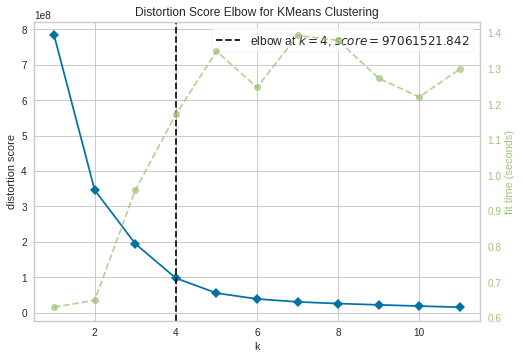

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [191]:
visualizer = KElbowVisualizer(KMeans(), k=(1,12))

visualizer.fit(rfm_modified)
visualizer.show()

Next again, having the `k` from the previous step, I could train the model and divide the dataset into cluster using it.

In [192]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=1).fit(rfm_modified)
rfm_modified["Cluster"] = kmeans.labels_

clusters = [rfm_modified[rfm_modified["Cluster"] == num] for num in rfm_modified["Cluster"].unique()]
for cluster in clusters:
    display(cluster.describe())

,Recency,Frequency,Monetary,Cluster
count,12070.000000,12070.000000,12070.000000,12070.0
mean,39.801657,1.069843,69.689981,0.0
std,23.665382,0.426184,54.278095,0.0
min,1.000000,1.000000,1.180000,0.0
25%,20.000000,1.000000,29.270000,0.0
50%,39.000000,1.000000,53.000000,0.0
75%,58.000000,1.000000,96.607500,0.0
max,101.000000,13.000000,254.650000,0.0


,Recency,Frequency,Monetary,Cluster
count,754.000000,754.000000,754.000000,754.0
mean,38.038462,1.417772,439.958607,3.0
std,22.547099,1.341642,256.685744,0.0
min,1.000000,1.000000,254.760000,3.0
25%,20.000000,1.000000,288.260000,3.0
50%,37.000000,1.000000,351.115000,3.0
75%,56.000000,1.000000,470.640000,3.0
max,95.000000,18.000000,2448.650000,3.0


,Recency,Frequency,Monetary,Cluster
count,1.0,1.0,1.00,1.0
mean,56.0,1.0,21001.05,1.0
std,NaN,NaN,NaN,NaN
min,56.0,1.0,21001.05,1.0
25%,56.0,1.0,21001.05,1.0
50%,56.0,1.0,21001.05,1.0
75%,56.0,1.0,21001.05,1.0
max,56.0,1.0,21001.05,1.0


,Recency,Frequency,Monetary,Cluster
count,4.000000,4.00000,4.000000,4.0
mean,26.250000,1.50000,6248.252500,2.0
std,16.317169,0.57735,1257.596301,0.0
min,11.000000,1.00000,4975.390000,2.0
25%,15.500000,1.00000,5503.315000,2.0
50%,23.000000,1.50000,6052.645000,2.0
75%,33.750000,2.00000,6797.582500,2.0
max,48.000000,2.00000,7912.330000,2.0


And here comes the new visualization. As we can see, the resulted clusters are completely different from the normal RFM ones, it is pretty interesting that that happened.

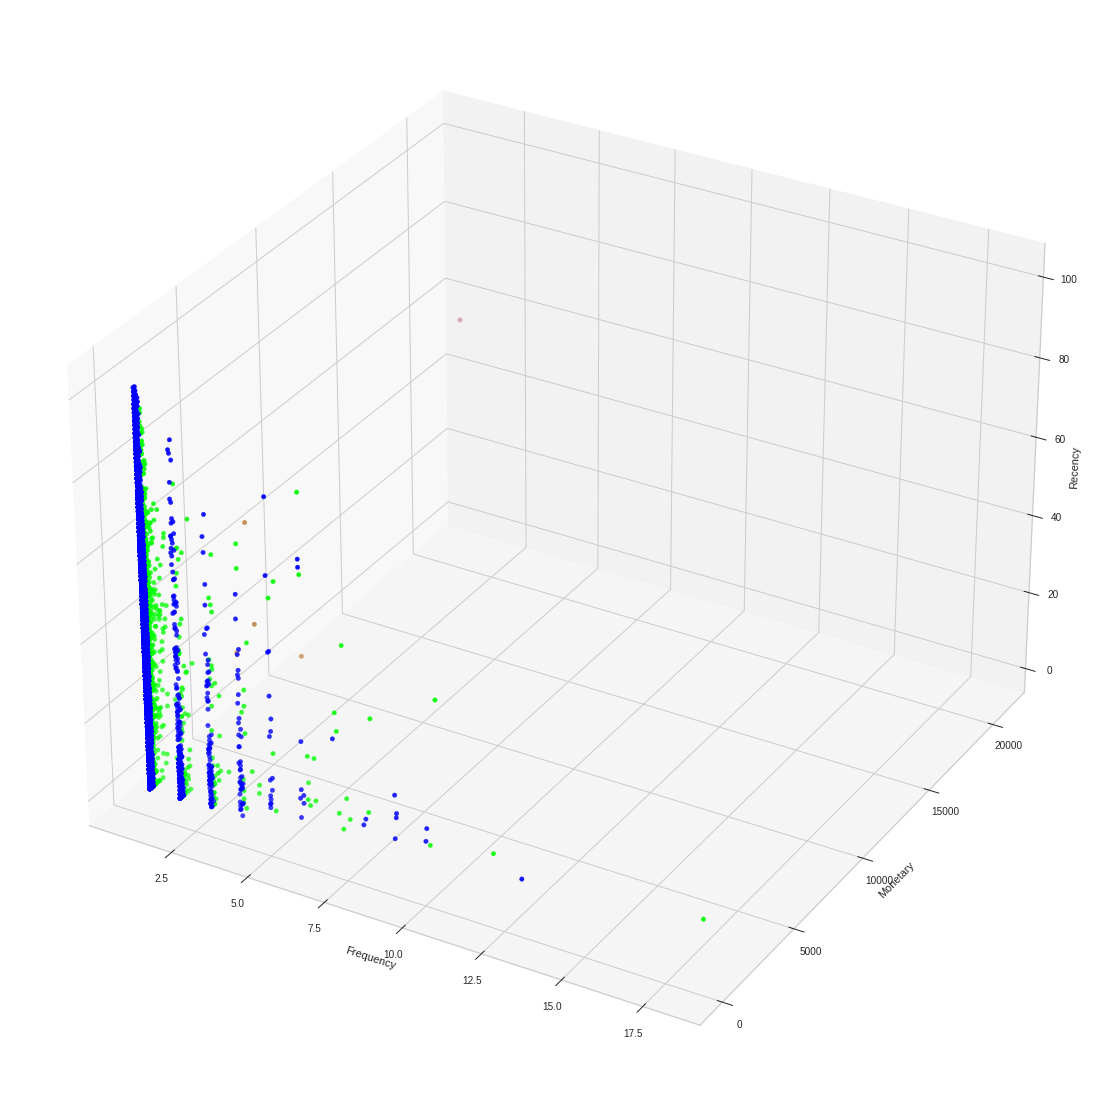

In [193]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm_modified["Frequency"], rfm_modified["Monetary"], rfm_modified["Recency"],
           c=rfm_modified["Cluster"], cmap="brg")
ax.set_xlabel("Frequency")
ax.set_ylabel("Monetary")
ax.set_zlabel("Recency")
plt.show()

Again, after the 3d visualization I provide the 2d projection to better understand those clusters:

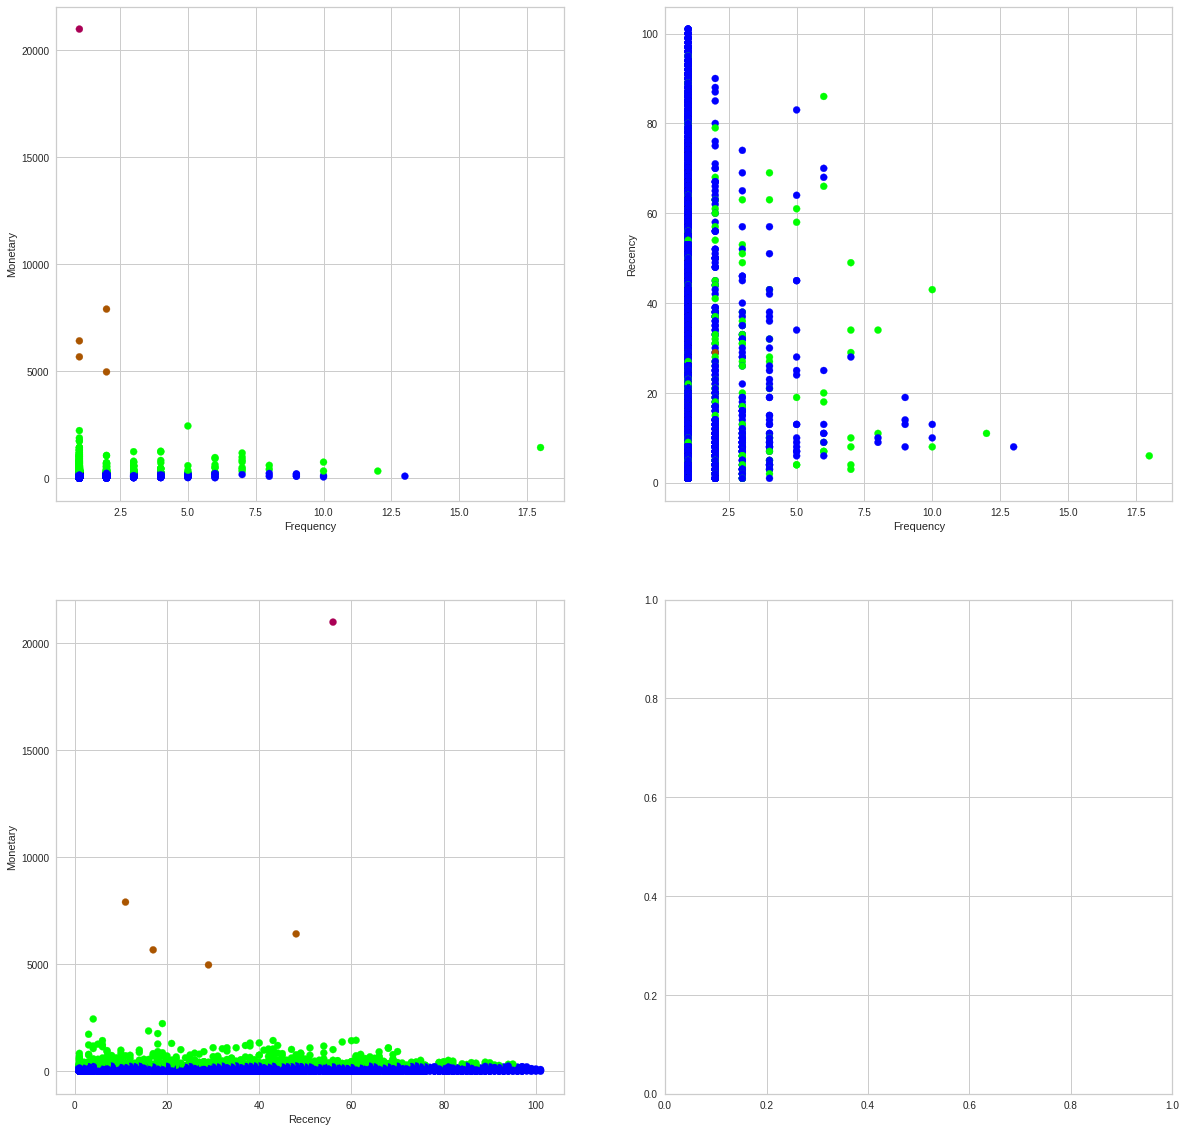

In [194]:
fig, ((ax1, ax2), (ax3, _)) = plt.subplots(2, 2, figsize=(20, 20))

ax1.scatter(rfm_modified["Frequency"], rfm_modified["Monetary"],
           c=rfm_modified["Cluster"], cmap="brg")
ax1.set_xlabel("Frequency")
ax1.set_ylabel("Monetary")

ax2.scatter(rfm_modified["Frequency"], rfm_modified["Recency"],
           c=rfm_modified["Cluster"], cmap="brg")
ax2.set_xlabel("Frequency")
ax2.set_ylabel("Recency")

ax3.scatter(rfm_modified["Recency"], rfm_modified["Monetary"],
           c=rfm_modified["Cluster"], cmap="brg")
ax3.set_xlabel("Recency")
ax3.set_ylabel("Monetary")

plt.show()

## Scaled modified RFM
To complete the bonus task, I needed to work with the modified dataset and scale it like the normal one. Again, I used the `sklearn.preprocessing.MinMaxScaler` for that.

In [195]:
column_names = ["Recency", "Frequency", "Monetary"]
rfm_modified_scaled = pd.DataFrame(MinMaxScaler().fit_transform(rfm_modified[column_names]), columns=column_names)
display(rfm_modified_scaled)

,Recency,Frequency,Monetary
0,0.35,0.0,0.000576
1,0.99,0.0,0.000572
2,0.98,0.0,0.001668
3,1.00,0.0,0.004039
4,1.00,0.0,0.001772
...,...,...,...
12824,0.00,0.0,0.001461
12825,0.00,0.0,0.000234
12826,0.00,0.0,0.007241
12827,0.00,0.0,0.000856


Here the resulted `k` is `3`, which is interesting, as we can come to a conclusion, that non-scaled RFM datasets have `k = 4` and scaled `k = 3`.

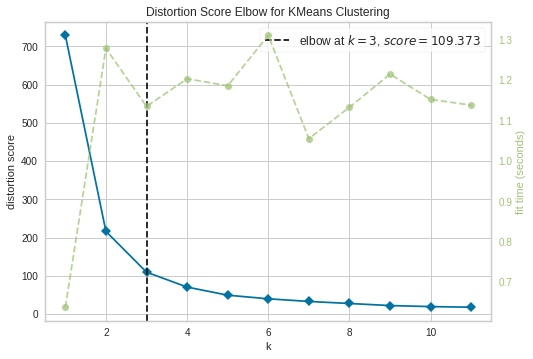

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [196]:
visualizer = KElbowVisualizer(KMeans(), k=(1,12))
visualizer.fit(rfm_modified_scaled)
visualizer.show()

Training the model again here and showing the clusters:

In [197]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=1).fit(rfm_modified_scaled)
rfm_modified_scaled["Cluster"] = kmeans.labels_

clusters = [rfm_modified_scaled[rfm_modified_scaled["Cluster"] == num] for num in rfm_modified_scaled["Cluster"].unique()]
for cluster in clusters:
    display(cluster.describe())

,Recency,Frequency,Monetary,Cluster
count,4651.000000,4651.000000,4651.000000,4651.0
mean,0.393307,0.002504,0.004641,2.0
std,0.078367,0.020981,0.007940,0.0
min,0.260000,0.000000,0.000022,2.0
25%,0.330000,0.000000,0.001452,2.0
50%,0.390000,0.000000,0.002833,2.0
75%,0.460000,0.000000,0.005636,2.0
max,0.530000,0.529412,0.305946,2.0


,Recency,Frequency,Monetary,Cluster
count,3885.000000,3885.000000,3885.000000,3885.0
mean,0.672535,0.001302,0.004124,1.0
std,0.101740,0.014625,0.016661,0.0
min,0.540000,0.000000,0.000024,1.0
25%,0.590000,0.000000,0.001334,1.0
50%,0.650000,0.000000,0.002443,1.0
75%,0.730000,0.000000,0.004658,1.0
max,1.000000,0.294118,1.000000,1.0


,Recency,Frequency,Monetary,Cluster
count,4293.000000,4293.000000,4293.000000,4293.0
mean,0.121621,0.012003,0.004592,0.0
std,0.078687,0.046822,0.009500,0.0
min,0.000000,0.000000,0.000000,0.0
25%,0.050000,0.000000,0.001408,0.0
50%,0.120000,0.000000,0.002659,0.0
75%,0.190000,0.000000,0.005136,0.0
max,0.260000,1.000000,0.376724,0.0


And here is a visualization for the scaled modified dataset. As we can see, the modified and scaled modified dataset clusters are completely different here, which was not observed in the normal dataset.

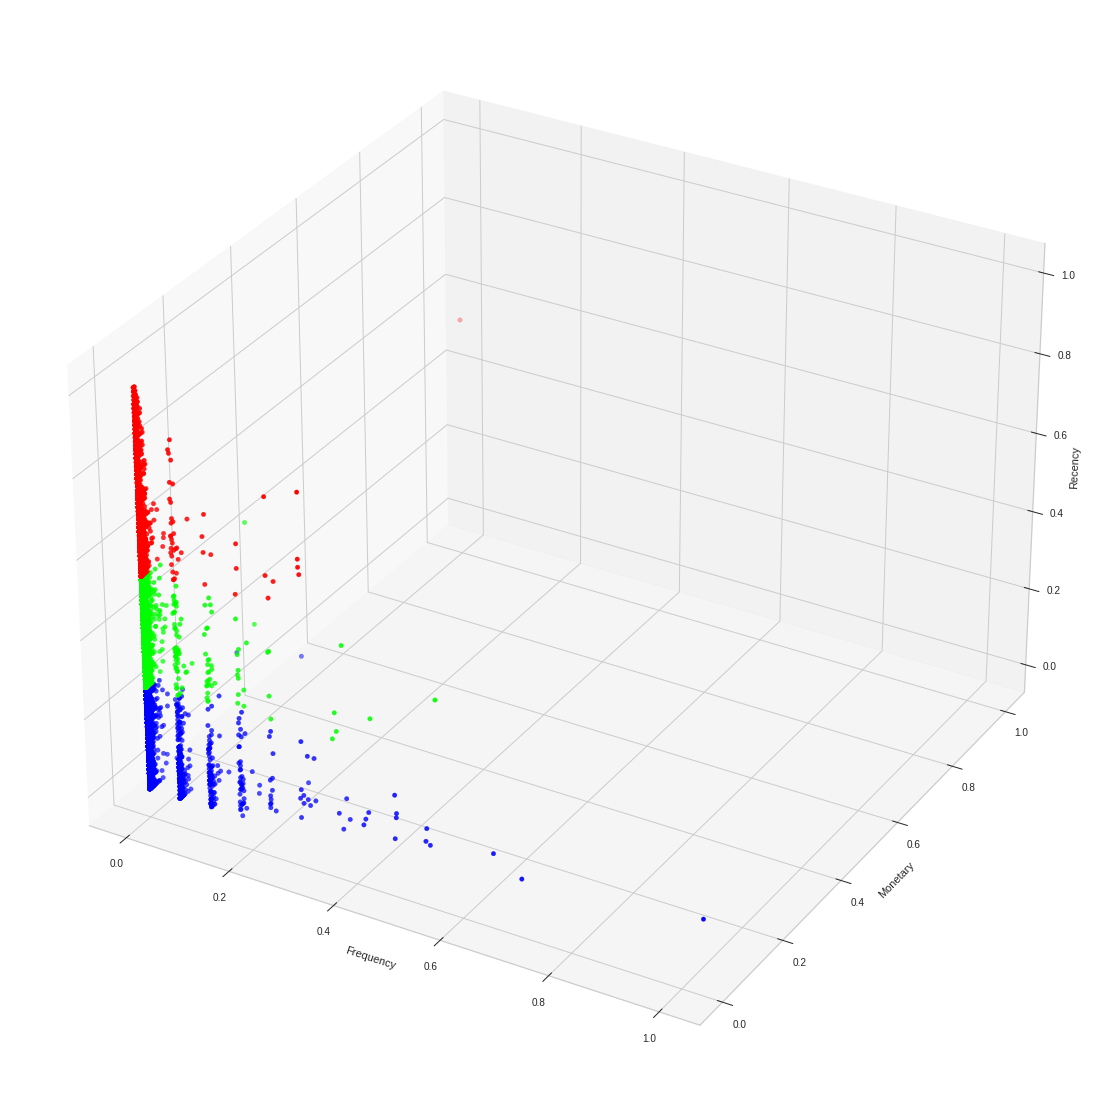

In [198]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm_modified_scaled["Frequency"], rfm_modified_scaled["Monetary"], 
           rfm_modified_scaled["Recency"], c=rfm_modified_scaled["Cluster"], cmap="brg")
ax.set_xlabel("Frequency")
ax.set_ylabel("Monetary")
ax.set_zlabel("Recency")
plt.show()

Finally, as usual, here are 2d scatter plots for better understanding:

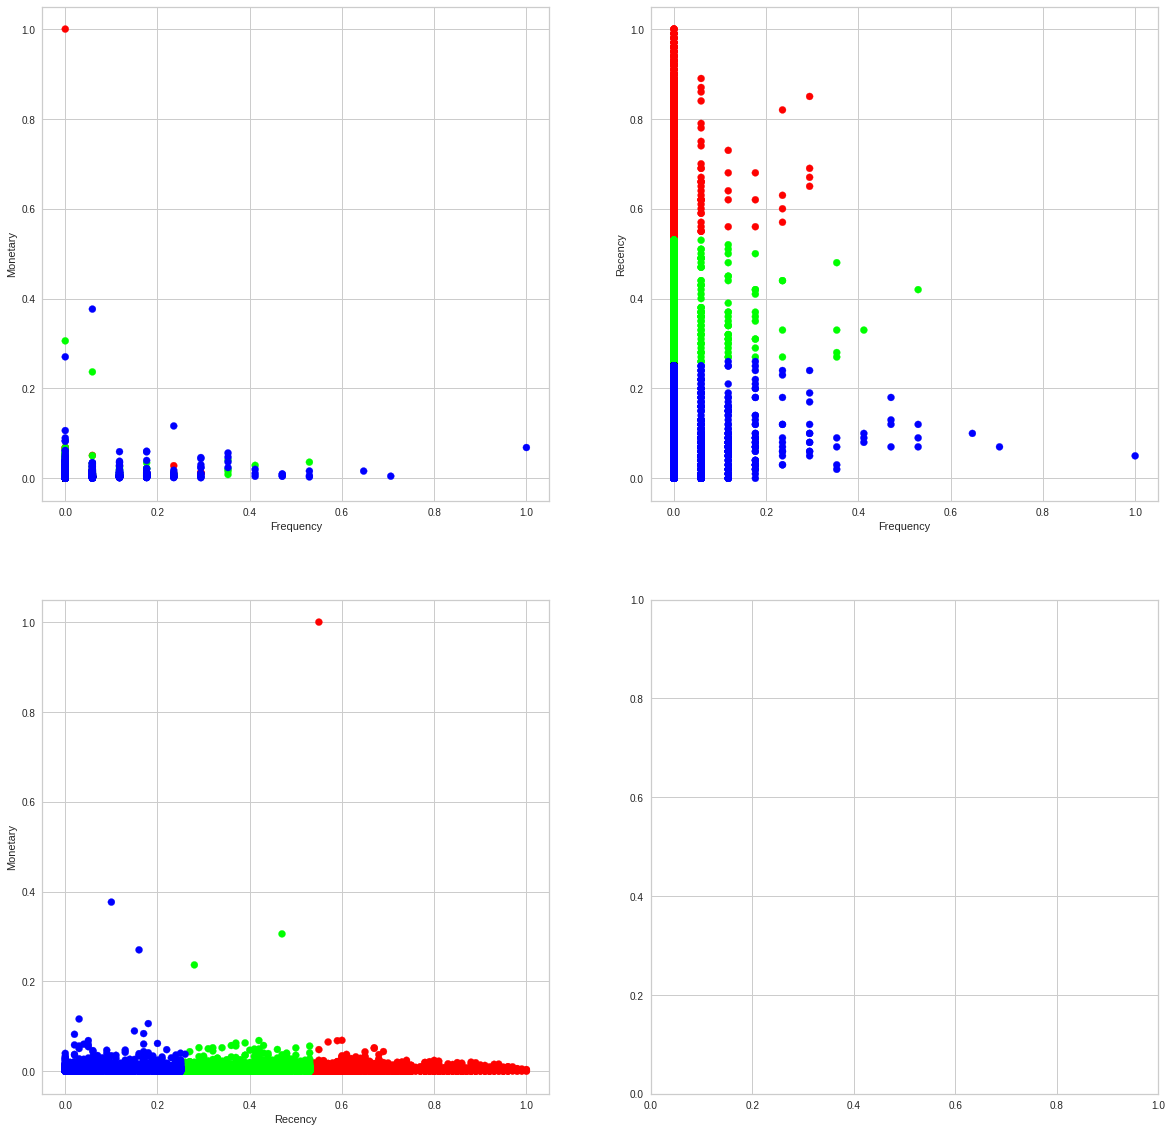

In [199]:
fig, ((ax1, ax2), (ax3, _)) = plt.subplots(2, 2, figsize=(20, 20))

ax1.scatter(rfm_modified_scaled["Frequency"], rfm_modified_scaled["Monetary"],
            c=rfm_modified_scaled["Cluster"], cmap="brg")
ax1.set_xlabel("Frequency")
ax1.set_ylabel("Monetary")

ax2.scatter(rfm_modified_scaled["Frequency"], rfm_modified_scaled["Recency"],
            c=rfm_modified_scaled["Cluster"], cmap="brg")
ax2.set_xlabel("Frequency")
ax2.set_ylabel("Recency")

ax3.scatter(rfm_modified_scaled["Recency"], rfm_modified_scaled["Monetary"],
            c=rfm_modified_scaled["Cluster"], cmap="brg")
ax3.set_xlabel("Recency")
ax3.set_ylabel("Monetary")

plt.show()